# check_gini.ipynb

Check the logic in the plugin, on fiji pixel data.

In [8]:
import pandas as pd
import numpy as np 

# Read all the sheets in cell_pixel_values.xlsx
xls = pd.ExcelFile('cell_pixel_values.xlsx')
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name)


In [37]:


def get_gini_on_pixels_2(pixels):
    '''Given an array of pixels, get the Gini coefficient
    
    This entails generating a histogram of pixel values, calculating the CDF,
    and then calculating the Gini coefficient from the CDF.

    Assumes intensties are always positive.
    '''
    sorted_pixels = np.sort(pixels.flatten())
    if np.all(sorted_pixels == 0):
        return 0
    
    cum_values = np.cumsum(sorted_pixels, dtype=float) 
    cum_values /= cum_values[-1]

    indices = np.arange(1, len(sorted_pixels) + 1)
    gini = 1 - 2 * np.sum((cum_values - indices / len(sorted_pixels)) / len(sorted_pixels))
    return gini


def get_gini_on_pixels(pixels):
    '''Given an array of pixels, get the Gini coefficient'''

    sorted_values = np.sort(pixels.flatten())
    
    mean = np.mean(sorted_values)
    
    n = len(sorted_values)
    cumulative_sum = np.cumsum(sorted_values)
    gini_numerator = np.sum((2 * np.arange(1, n+1) - n - 1) * cumulative_sum)
    gini_denominator = n * np.sum(sorted_values)
    gini = (1 / (n * mean)) * (gini_numerator / gini_denominator)
    
    return gini


def gini_coefficient(pixels):
    n = len(pixels)
    r = np.apply_along_axis(lambda x: np.argsort(x), 0, pixels)
    s = np.sum(pixels)
    sum_r = np.sum((n - r) * pixels)
    gini = 1 - (2 * sum_r - s) / (n * s)
    return gini

In [38]:
import pandas as pd
import numpy as np

def calculate_gini(df):
    # Sorting the DataFrame by bin number
    df_sorted = df.sort_values('bin_number')
    
    # Calculating cumulative population and cumulative wealth
    df_sorted['cumulative_population'] = df_sorted['frequency'].cumsum()
    df_sorted['cumulative_wealth'] = df_sorted['bin_number'] * df_sorted['frequency']
    df_sorted['cumulative_wealth'] = df_sorted['cumulative_wealth'].cumsum()
    
    # Normalizing the cumulative values to go from 0 to 1
    total_population = df_sorted['frequency'].sum()
    total_wealth = df_sorted['bin_number'].dot(df_sorted['frequency'])
    df_sorted['cumulative_population'] /= total_population
    df_sorted['cumulative_wealth'] /= total_wealth

    # Adding (0,0) as the starting point for Lorenz curve
    lorenz_points = pd.concat([pd.DataFrame({'cumulative_population': [0], 'cumulative_wealth': [0]}),
                               df_sorted[['cumulative_population', 'cumulative_wealth']]])

    # Calculating the area under the Lorenz curve using the trapezoidal rule
    area_under_lorenz = np.trapz(lorenz_points['cumulative_wealth'], lorenz_points['cumulative_population'])

    # Gini coefficient is 1 - 2 * area under the Lorenz curve
    gini_coefficient = 1 - 2 * area_under_lorenz
    return gini_coefficient

# Example DataFrame
data = {
    'bin_number': [1, 2, 3, 4, 5],  # Example bin numbers
    'frequency': [10, 20, 30, 25, 15]  # Example frequencies
}
df = pd.DataFrame(data)

# Calculate Gini coefficient
# gini_coefficient = calculate_gini(df)
# print("Gini Coefficient:", gini_coefficient)

In [40]:
for name, sheet in sheet_to_df_map.items():
    hist, _ = np.histogram(sheet.values)
    df = pd.DataFrame({'bin_number': range(len(hist)), 'frequency': hist})
    print(name,
           get_gini_on_pixels(sheet.values),
             calculate_gini(df),
               gini_coefficient(sheet.values.flatten()), 
               get_gini_on_pixels_2(sheet.values)
    )


spot_cell1 0.0009871598506813006 0.871500120618308 0.01090125689201904 1.0913956152542617
spot_cell2 0.0008810436495270134 0.8107279409811163 0.028999748839063977 1.1353461351910867
spot_cell3 0.0009446751784375515 0.9347834262558644 0.029093427662439275 1.1100070236669346
spot_cell4 0.0009799976295398571 0.9494475891700198 0.0023172943468358076 1.0986256298668848
spot_cell5 0.0009301623566072118 0.6717689743336877 0.008776247242351598 1.1193364427694055
nospot_cell1 0.0010241727789810763 0.32277552376380947 0.0020518881888913487 1.0561731142487887
nospot_cell2 0.0010947658781050773 0.26375249738592377 -0.0007464038269799911 1.0408459404134005
nospot_cell3 0.001047447762712282 0.337731306608235 0.001414519118661306 1.0604812337112413
nospot_cell4 0.001123694938973693 0.3080956575231384 0.004649427118837535 1.0496390140160996
nospot_cell5 0.001148349045148195 0.2841773412193539 0.0005080363937630672 1.0410462269189622


In [49]:
import numpy as np

def gini_from_pixel_array(pixel_array_2d):
    pixel_array_1d = pixel_array_2d.flatten()
    sorted_pixel_array = np.sort(pixel_array_1d)
    cumulative_pixel_values = np.cumsum(sorted_pixel_array)
    total_pixel_values = cumulative_pixel_values[-1]
    normalized_cumulative = cumulative_pixel_values / total_pixel_values
    n = len(sorted_pixel_array)
    lorenz_area = np.sum(normalized_cumulative) - (0.5 / n) - 0.5
    gini_coefficient = (0.5 - lorenz_area) / 0.5
    return gini_coefficient



for name, sheet in sheet_to_df_map.items():
    print(name, gini_from_pixel_array(sheet.values) )


spot_cell1 -3869.6544442750615
spot_cell2 -4467.530979834011
spot_cell3 -5185.878894483656
spot_cell4 -3687.42367820543
spot_cell5 -5286.503831056861
nospot_cell1 -7597.750132974828
nospot_cell2 -6025.364797222968
nospot_cell3 -3683.792346412559
nospot_cell4 -3458.3137142561227
nospot_cell5 -4817.742510727239


In [52]:
pixel_array_2d = sheet.values
pixel_array_1d = pixel_array_2d.flatten()
sorted_pixel_array = np.sort(pixel_array_1d)
cumulative_pixel_values = np.cumsum(sorted_pixel_array)
total_pixel_values = cumulative_pixel_values[-1]
normalized_cumulative = cumulative_pixel_values / total_pixel_values
n = len(sorted_pixel_array)
lorenz_area = np.sum(normalized_cumulative) - (0.5 / n) - 0.5
gini_coefficient = (0.5 - lorenz_area) / 0.5
print(gini_coefficient)

-4817.742510727239


In [54]:
pixel_array_2d.shape

(67, 75)

In [56]:
n

5025

In [57]:
lorenz_area

2409.3712553636196

In [93]:
def gini_from_pixel_array(pixel_array_2d):
    # Flatten the 2D array into a 1D array.
    pixel_array_1d = pixel_array_2d.flatten()
    n = len(pixel_array_1d)
    mean_pixel_value = np.mean(pixel_array_1d)
    
    # Calculate the sum of absolute differences.
    abs_diff_sum = np.sum(np.abs(pixel_array_1d[:, None] - pixel_array_1d))
    
    # Apply the Gini coefficient formula.
    gini_coefficient = abs_diff_sum / (2.0 * n**2 * mean_pixel_value)
    
    return gini_coefficient

ginis = []
for name, sheet in sheet_to_df_map.items():
    hist, _ = np.histogram(sheet.values, bins=1_000_000)
    df = pd.DataFrame({'bin_number': range(len(hist)), 'frequency': hist})

    print(name, gini_from_pixel_array(sheet.values), calculate_gini(df))
    label = 'nospot' not in name

    ginis.append((name, label, gini_from_pixel_array(sheet.values), calculate_gini(df)))

spot_cell1 0.09139561525426168 0.39231125922543175
spot_cell2 0.13534613519108665 0.4375363556890858
spot_cell3 0.11000702366693461 0.41392546200996005
spot_cell4 0.09862562986688489 0.40345291698666463
spot_cell5 0.1193364427694055 0.4212840741751249
nospot_cell1 0.05617311424878876 0.25086255466281926
nospot_cell2 0.040845940413400415 0.21776953871651916
nospot_cell3 0.0604812337112413 0.28316946467922255
nospot_cell4 0.049639014016099665 0.24515418450236415
nospot_cell5 0.041046226918962286 0.23384529597301784


In [72]:
def genie(data):    
    flattened = np.sort(np.ravel(data))
    npix = np.size(flattened)
    normalization = np.abs(np.mean(flattened)) * npix * (npix - 1)
    kernel = (2.0 * np.arange(1, npix + 1) - npix - 1) * np.abs(flattened)

    return np.sum(kernel) / normalization


ginis = []
for name, sheet in sheet_to_df_map.items():
    hist, _ = np.histogram(sheet.values)
    df = pd.DataFrame({'bin_number': range(len(hist)), 'frequency': hist})

    print(name, gini_from_pixel_array(sheet.values), genie(sheet.values))
    ginis.append((label, gini_from_pixel_array(sheet.values), genie(sheet.values)))


spot_cell1 0.09139561525426168 0.09141707466145921
spot_cell2 0.13534613519108665 0.1353723295272955
spot_cell3 0.11000702366693461 0.11002590251087951
spot_cell4 0.09862562986688489 0.09864973781845343
spot_cell5 0.1193364427694055 0.11935632223680002
nospot_cell1 0.05617311424878876 0.05618009227540351
nospot_cell2 0.040845940413400415 0.040852442473319775
nospot_cell3 0.0604812337112413 0.060496658662455585
nospot_cell4 0.049639014016099665 0.04965265485534564
nospot_cell5 0.041046226918962286 0.04105439694820571


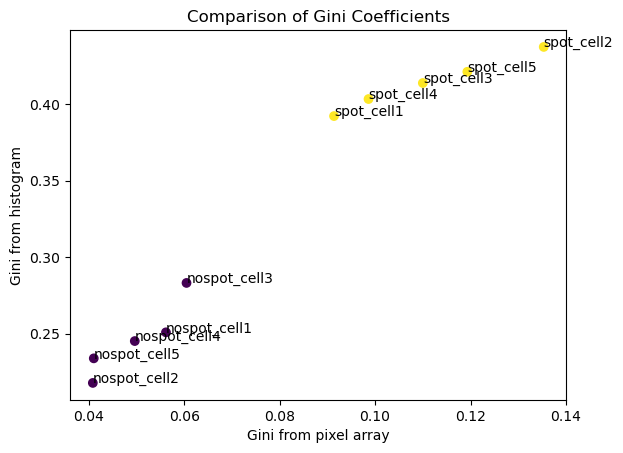

In [96]:

import matplotlib.pyplot as plt 

names, labels, gini_vals, genies = zip(*ginis)

plt.scatter(gini_vals, genies, c=labels)

for i, name in enumerate(names):
    plt.annotate(name, (gini_vals[i], genies[i]))

plt.xlabel('Gini from pixel array')
plt.ylabel('Gini from histogram')
plt.title('Comparison of Gini Coefficients')
plt.show()
